# Purpose
* Working through the question plate for chapter 2 of MBML

In [1]:
import operator
from functools import reduce
from typing import Callable, Dict, List

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, log_likelihood
from numpyro.infer.util import log_density, potential_energy

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p arviz,jax,matplotlib,numpy,pandas,scipy,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

arviz     : 0.11.2
jax       : 0.2.19
matplotlib: 3.4.3
numpy     : 1.20.3
pandas    : 1.3.2
scipy     : 1.6.2
numpyro   : 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 307321cc497d1542d2908d60950823b102b16219

Git branch: master



In [5]:
rng_key = jax.random.PRNGKey(2)

### Get Data

In [6]:
raw_data = pd.read_csv(
    "http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-RawResponsesAsDictionary.csv"
)
self_assessed = raw_data.iloc[1:, 1:8].copy()
self_assessed = self_assessed.astype(int)

skills_key = pd.read_csv(
    "http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-Quiz-SkillsQuestionsMask.csv",
    header=None,
)
skills_needed = []
for index, row in skills_key.iterrows():
    skills_needed.append([i for i, x in enumerate(row) if x])

responses = pd.read_csv(
    "http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-IsCorrect.csv",
    header=None,
)

responses = responses.astype("int32")

In [7]:
def model_03(
    graded_responses, skills_needed: np.array, prob_mistake=0.1, prob_guess=0.2
):
    assert graded_responses.shape[0] == skills_needed.shape[0]
    n_questions, n_participants = graded_responses.shape
    n_skills = skills_needed.shape[1]

    questions_plate = numpyro.plate("questions_plate", n_questions)

    # skills.shape == (n_participants, n_skills)
    with numpyro.plate("participants_plate", n_participants, dim=-2):
        with numpyro.plate("skills_plate", n_skills):
            skills = numpyro.sample("skill", dist.Bernoulli(0.5))

    with questions_plate:
        # shape: people x questions x skills
        # astype(bool) is needed for the log density
        relevant_skills = skills[:, None, :].astype(bool) | (~skills_needed)
        # shape: people x questions
        has_skill = jnp.all(relevant_skills, -1)
        prob_correct = has_skill * (1 - prob_mistake) + (1 - has_skill) * prob_guess
        is_correct = numpyro.sample(
            "isCorrect", dist.Bernoulli(prob_correct), obs=graded_responses.T
        )

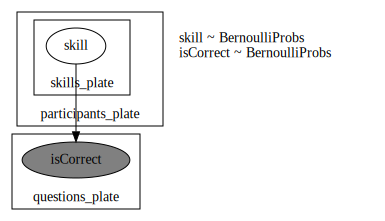

In [8]:
numpyro.render_model(
    model_03,
    (jnp.array(responses), jnp.array(skills_key.astype(bool))),
    dict(prob_mistake=0.1),
    render_distributions=True,
)

In [9]:
nuts_kernel = NUTS(model_03)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc_03 = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc_03.run(
    rng_key,
    jnp.array(responses),
    jnp.array(skills_key.astype(bool)),
    extra_fields=(
        "z",
        "hmc_state.potential_energy",
        "hmc_state.z",
        "rng_key",
        "hmc_state.rng_key",
    ),
)
mcmc_03.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1200/1200 [00:02<00:00, 525.62it/s, 1 steps of size 1.18e+37. acc. prob=1.00]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 skill[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill[0,1]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill[0,2]      0.98      0.13      1.00      1.00      1.00   4007.27      1.00
 skill[0,3]      0.99      0.09      1.00      1.00      1.00   3523.86      1.00
 skill[0,4]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill[0,5]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill[0,6]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill[1,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill[1,1]      1.00      0.05      1.00      1.00      1.00   4027.48      1.00
 skill[1,2]      0.59      0.49      1.00      0.00      1.00  21255.70      1.00
 skill[1,3]      0.99      0.09      1.00      1.00      1.00   3855.32      1.00
 skill[1,4]    

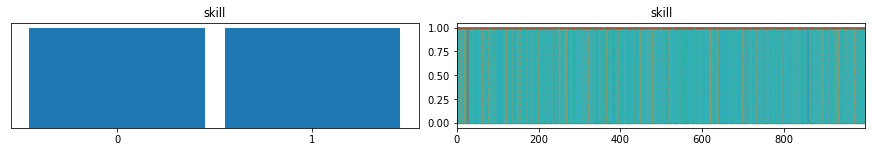

In [10]:
ds = az.from_numpyro(mcmc_03)
az.plot_trace(ds);

### Explaining the bit operations

* The bitwise `OR` and `~` may seem trivail to some or opaque to others. Reguardless, the operation is significant because it allows for efficient use of the `plate` primitive which speeds up the code.
*  When following the MBML book you may recognize the author use of the `AND` factor when two skills are needed for a question, yet our model uses the `OR`, hopefully the example below will explain how and why this works
* The credit for the approach goes all to @fehiepsi (from the Pyro forums), the example is only to convience myself and others why this works.
* Below is the snippet of code, we will first consider a single participant and question with seven possible skills

```python
# skills_needed is boolean with shape num_questions x num_skills
# skills.shape == (num_participants, num_skills)
relevant_skills = skills[:, None, :].astype(bool) | (~skills_needed)
```

Consider the example:

A participant, $p_i$ has skills $[0, 1, 0, 1, 1, 1, 1]$ 

A question, $q_j$ the required skills are $[0, 1, 0, 0, 0, 0, 1]$

In [11]:
s = jnp.array([0, 1, 0, 1, 1, 1, 1])
q = skills_key.values[7]

1. `AND` operatoin:

In [12]:
print(f"s={s.astype(bool)}")
print(f"q={q}")
print(s & q)
print(f"all={jnp.all(s & q)}")

s=[False  True False  True  True  True  True]
q=[False  True False False False False  True]
[0 1 0 0 0 0 1]
all=False


* The `AND` operation does work to identify the match between the participant and the required skills, but thinking in terms of per skill, per participant hinders the ues of vectorizing over the questions with a `plate` primitive. 
* We want move from knowing if particular skills match between participant and question and simply indicate the if participant simply has the needed skills to answer the question

2. `OR` operatoin:

In [13]:
print(f"s={s.astype(bool)}")
print(f"q={q}")
print(s | q)
print(f"all={jnp.all(s | q)}")

s=[False  True False  True  True  True  True]
q=[False  True False False False False  True]
[0 1 0 1 1 1 1]
all=False


* The `OR` operation alone doesn't work, since the resulting bit vector is indicating if either the participant or the skills needed are present (which alone is useless information)
* In hindsight, we need to add another operatoin to achieve our goal, the give away is the use of `jnp.all`

3. `OR` operatoin with `~`:

In [14]:
print(f"s={s.astype(bool)}")
print(f"q={q}")
print(f"~q={~q}")
print(s | ~q)
print(f"all={jnp.all(s | ~q)}")

s=[False  True False  True  True  True  True]
q=[False  True False False False False  True]
~q=[ True False  True  True  True  True False]
[1 1 1 1 1 1 1]
all=True


* comparing between 2. and 3. the `~` gives us the desired effect where skills that match remain `True` and all other skills result in a `True` allowing for `jnp.all` to verify the participant has the nesscary skill for the question.
* The final example shows the use of `OR` and `~` when participant doesn't have the nesscary skills to answer the question:

In [15]:
print(f"s={s.astype(bool)}")
print(f"q={skills_key.values[6]}")
print(f"~q={~skills_key.values[6]}")
print(s | ~skills_key.values[6])
print(f"all={jnp.all(s | ~skills_key.values[6])}")

s=[False  True False  True  True  True  True]
q=[ True False False False False False  True]
~q=[False  True  True  True  True  True False]
[0 1 1 1 1 1 1]
all=False


### Broadcasting to utilize `plate`
* The bitwise `OR` and `~` is only half the puzzle to utilize the `plate`, we still have to worry about how to vectorize the skills needed check under the question plate.
* For the problem a key insight is the skills of an individual are not changing throught the test and therefore we can calculate the `has_skill` all at once
* For convience, the relevant snippet is shown again:
```python
# skills_needed is boolean with shape num_questions x num_skills
# skills.shape == (num_participants, num_skills)
relevant_skills = skills[:, None, :].astype(bool) | (~skills_needed)
# shape: people x questions
has_skill = jnp.all(relevant_skills, -1)
prob_correct = has_skill * (1 - prob_mistake) + (1 - has_skill) * prob_guess
```

* `logical_or` == `|` and is done elementwise, therefore looking over examples of broadcasting just imaging the `OR` operation
* s[:, None, :] view it as 22 x (1,7) np.array then from there explain the broadcast ...
* s[:, None, :] | (~skills_key.values)

In [16]:
# In our data there are: 22 people, 48 questions, and 7 skills
s = dist.Bernoulli(0.5 * jnp.ones((22, 7))).sample(rng_key)
s.shape

(22, 7)

In [ ]:
(s[:, None, :] | (~skills_key.values)).shape

In [ ]:
r_s = s[:, None, :] | (~skills_key.values)

In [ ]:
s[:, None, :][19]

In [ ]:
(~skills_key.values).shape

In [ ]:
b = np.broadcast(s[:, None, :], (~skills_key.values))

In [ ]:
len(list(b))

In [ ]:
22 * 48 * 7

In [ ]:
r_s = (s[:, None, :] | (~skills_key.values))
r_s.shape

In [ ]:
# (22,48)x7
r_s[:,:,0].shape

In [ ]:
# 22x(48,7)
r_s[0].shape

In [ ]:
# (22,7)x48
r_s[:,0,:].shape

In [ ]:
# (22, 48)
jnp.all(r_s, 2)[0,0]

In [ ]:
jnp.all(r_s, 2).shape

In [ ]:
s[0,:]

In [ ]:
(s[:, None, :].astype(bool) | ~skills_key.values)[0]

In [ ]:
jnp.all(r_s)

In [ ]:
h_s = jnp.all(r_s, -1)
h_s.shape

In [ ]:
h_s[0]

In [ ]:
p_c = h_s * (1 - 0.1) + (1 - h_s) * 0.2
p_c.shape

In [ ]:
h_s[0][:8]

In [ ]:
p_c[0][:8]

In [ ]:
self_assessed.shape

In [ ]:
s = dist.Bernoulli(0.5 * jnp.ones((22, 7))).sample(rng_key)

In [ ]:
s.shape

In [ ]:
s[0]

In [ ]:
skills_key.values[25]

In [ ]:
s[0] & skills_key.values[25]

In [ ]:
n_ = 6
print("bitwise ADND")
print(f"s={s[0].astype(bool)}")
print(f"q={skills_key.values[n_]}")
print(s[0] & skills_key.values[n_])
print(f"all={jnp.all(s[0] & skills_key.values[n_])}")
print("bitwise OR")
print(f"s={s[0].astype(bool)}")
print(f"q={skills_key.values[n_]}")
print(s[0] | (~skills_key.values[n_]))
print(f"all={jnp.all(s[0] | (~skills_key.values[n_]))}")

In [ ]:
(s[0] | (~skills_key.values))[25]

In [ ]:
(s[:, None, :] | (~skills_key.values))[0]

In [ ]:
jnp.all(r_s, -1).shape

In [ ]:
skills_key.astype(bool).sum(1).max()

In [ ]:
skills_key.shape

In [ ]:
responses.shape